<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#baseline" data-toc-modified-id="baseline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>baseline</a></span></li><li><span><a href="#Downsample" data-toc-modified-id="Downsample-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Downsample</a></span></li><li><span><a href="#Настройка-гиперпараметров-SGDClassifier" data-toc-modified-id="Настройка-гиперпараметров-SGDClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Настройка гиперпараметров SGDClassifier</a></span></li><li><span><a href="#Оптимизация-TF-IDF" data-toc-modified-id="Оптимизация-TF-IDF-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Оптимизация TF-IDF</a></span></li></ul></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект по анализу текста БЕЗ BERT

**Цель проекта:** создать прототип модели для интернет-магазина, который будет искать токсичные комментарии и отправлять их на модерацию.

**Ход проекта**

1. Осмотр данных;
2. Анализ и предобработка данных;
3. Обучение baseline моделей;
4. Улучшение моделей;
5. Проверка на тестовой выборке;
6. Выводы

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

from time import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier

from sklearn.utils import resample, shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

/tmp/ipykernel_187/2276515754.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

Считаем данные из файла.

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
def info_dataset(data):
    
    '''
    Функция выводит необходимую информацию о датасете методами:
    1. .sample - смотрим на случайные значения из датасета
    2. .info - общая информация о датасете
    3. .shape - смотрим размерность датасета
    4. .isna - смотрим пропуски в датасете    
    '''
    
    print('Случайные 5 строк датасета')
    display(data.sample(10))
    
    print('Информация о датасете')
    display(data.info())
    
    print('Размер датасета: {}'.format(data.shape))
    
    print('Количество пропусков в датасете: {}'.format(data['text'].isna().sum()))

In [5]:
info_dataset(df)

Случайные 5 строк датасета


,text,toxic
50663,"Congratulations \nI don’t know whether you are aware of this fact or not, but with this sentence: “Also, places like Lviv/Lwow, Tarnopil/Tarnopol etc are not in Malopolska” you have shown you qualified stupidity. I also see that “discussions” of morons veil the truth about the genocide of the Polish Nation. Congratulations. Now you can cry and run to report my “abuse”.",0
155222,"""\n\n Image:Futuramapilot.jpg \n\nUser:OrphanBot put the """"this image will be deleted in 7 days"""" on Image:Futuramapilot.jpg. The reason to not delete the image is I have re-added it to Space Pilot 3000.\n """,0
1369,"""\n\n V6FS Max Size \n\nThis may sound random, but Wikipedia led me astray on my home work and I should try to prevent it for others. The given max size in:\n""""The actual maximum was 8,847,360 bytes, with 7 singly-indirect blocks and 1 doubly-indirect block; PWB/UNIX 1.0's variant had 8 singly-indirect blocks, making the maximum 524,288 bytes or half a MiB.""""\nis incorrect.\nAccording to the Version 6 Manual, http://wwwlehre.dhbw-stuttgart.de/~helbig/os/v6/doc/V/fs.html, the max size is 32, but cannot be larger than 16 bue to only storing 24-bits of filesize info in each inode rather than 25. The 8,847,360 number obtained above was the result of calculating it with 4 byte addresses, which is obviously incorrect given the definition in the manual. """,0
66918,"Tony, Happy to help. I'm a bit busy at the moment, but will get round to it in the next few days.",0
41838,"You're wrong simi, I cannot live on two different continents. 128.6 is you btw. Someone check. hganesan",0
36223,Francs2000 died of AIDS,0
128834,"She's not best known as something from Sonic\nShe is easily best known as Phil and Lil from Rugrats, come on, the show lasted what, ten+ years and had a few movies, how would a character on a show that nobody but sonic fans remembers be remembered more than Phil and Lil?",0
98988,"""I just replied here to make it faster: It's most likely better to add to the top of the article, that way it can be reviewed and any problems addressed before it is moved. Once it's in articlespace (i.e. without any PREFIX:), it's more likely to be just outright deleted instead of having problems fixed ) talkediting """,0
151837,why is this page blank?!,0
8645,"Do the following two statements refer to the same event?\n\nOn April 5, Serbian policemen attacked police stations and then an Interior Ministry training school.\nAlso on April 6 Yugoslav People's Army (JNA) forces, Serb police units and paramilitaries attacked the Bosnian government’s personnel training center.\n\nIf so, we should note it just once, and get the participants right; and also we need to establish the correct date.",0


Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

Размер датасета: (159571, 2)
Количество пропусков в датасете: 0


**Выводы**

1. В данных отсутствуют пропуски;
2. Датасет содержит 159571 комментарий;
3. Данные содержат различные знаки. В дальнейшем требуется предобработка.

## Предобработка данных

Исследуем целевой признак `toxic`. Рассмотрим распределение целевого признака

In [6]:
def target_analysis(data):
    target = data['toxic']
    
    info = pd.DataFrame(
        data = { 'count' : target.value_counts(),
                 'normalize' : target.value_counts(normalize=True) * 100           
        }
    ).rename(index = {0 : 'neutral', 1 : 'toxic'})
    
    f, ax = plt.subplots()
    
    sns.barplot(x=info.index, y=info['count'], ax=ax)
    ax.set_title('Количество комментариев в зависимости от тональности')
    
    return info

,count,normalize
neutral,143346,89.832112
toxic,16225,10.167888


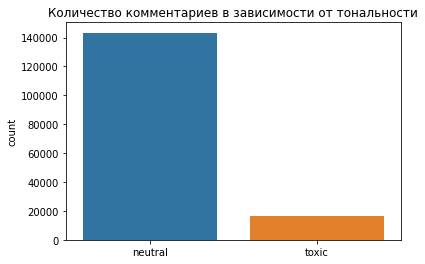

In [7]:
target_analysis(df)

**Вывод**

В датасете наблюдается сильная несбалансированность. Токсичных комментариев всего 10% от всей выборки. Этот факт необходимо учитывать при построении модели.

Произведем предобработку комментариев, а именно:
1. Удалим символы;
2. Удалим стоп-слова;
3. Произведем лемматизацию.

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(data, stop_words, lemmatizer):
    
    '''
    Функция очищает датасет от символов, стоп-слов и производит лемматизацию
    с помощью вспомогательной функции clean_comment
    '''
    
    def clean_comment(comment):
        
        pattern = r'[^a-zA-Z ]'
        comment_wo_punct = re.sub(pattern, ' ', comment).lower()
        comment_wo_stopwords = [word for word in comment_wo_punct.split() if word not in stop_words]
        clean_text = [lemmatizer.lemmatize(word) for word in comment_wo_stopwords]
        
        return ' '.join(clean_text)
    
    data['clean_text'] = data['text'].apply(lambda comment: clean_comment(comment))
    data = data.drop(columns=['text'])
    
    return data

In [9]:
clean_data = clean_text(df, stop_words, lemmatizer)

In [10]:
clean_data.sample(2)

,toxic,clean_text
29529,0,please advise input appreciated also active wikipedia created page local access tv show called m divine tee hee heure unfortunately deleted deemed un notable upon looking definition unnotable wikipedia state notable backed external site entry posted external site discus local tv show please advise checked appears page deleted thanks peterweller
67224,0,nope day animated family get money comedy


Для визуального представления воспользуемся WordCloud

In [11]:
def plot_wordcloud(data, is_toxic=True, total=False):
    
    '''
    Функция возвращает облако слов в зависимости от типа флага:
    1. is_toxic = True/False - показать облако слов для токсичных/нейтральных комментариев
    2. total = True/False - показать облако слов для всех комментариев
    '''
    
    def cloud(data, comment):
        
        '''
        Функция рисует облако слов.
        '''
        wordcloud = WordCloud(width=2000,
                              height=1000,
                              random_state=17,
                              background_color='black',
                              colormap='Set2',
                              collocations=False).generate(' '.join(data.values))
            
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud)
        plt.title(comment)
        plt.axis('off')
            
    if total:
        return cloud(data['clean_text'], 'Все комментарии')
    
    if is_toxic:
        temp_data = data[data['toxic']==1]
        return cloud(temp_data['clean_text'], 'Токсичные комментарии')
        
    else:
        temp_data = data[data['toxic']==0]
        return cloud(temp_data['clean_text'], 'Нейтральные комментарии')

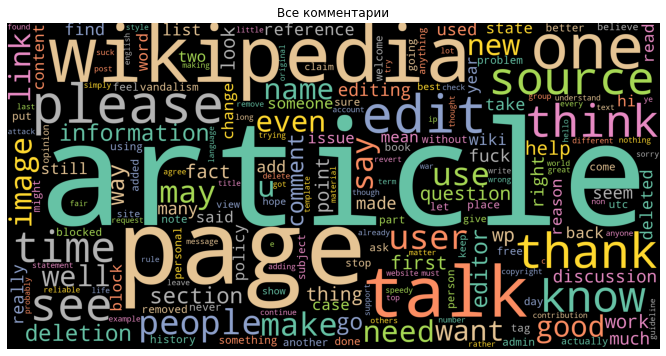

In [12]:
plot_wordcloud(df, is_toxic=True, total=True)

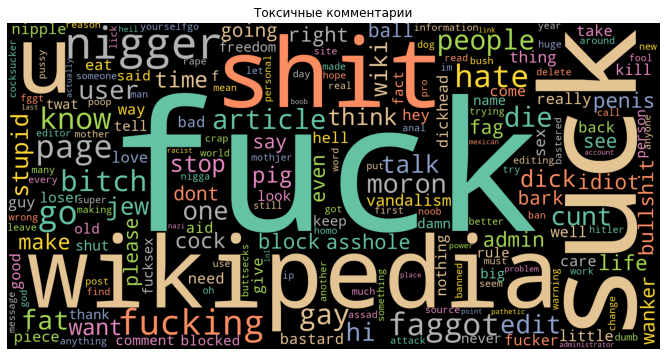

In [13]:
plot_wordcloud(df, is_toxic=True)

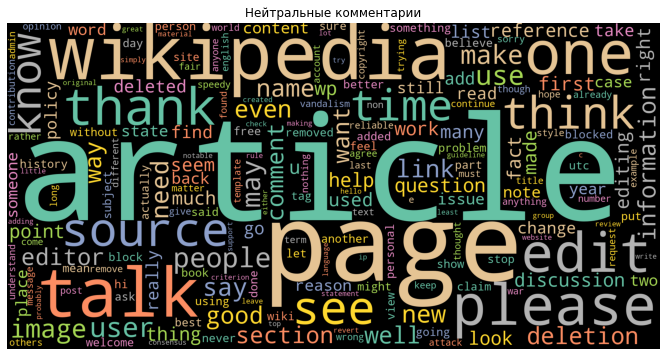

In [14]:
plot_wordcloud(df, is_toxic=False)

**Вывод**

В данном разделе была произведена очистка датасета от пунктуации, стоп слов и произведена лемматизация. С помощью WordCloud получили наглядное изображение наиболее употребляемых слов для всех групп комментариев (для всех/токсичных/нейтральных).

## Обучение

Перейдем к обучению моделей.

### baseline

Будем использовать 3 модели:
1. LogisticRegression
2. CatBoostClassifier
3. LGBMClassifier

Выделим признаки и таргет

In [15]:
features, target = clean_data['clean_text'].astype('U'), clean_data['toxic']

Разделим датасет на 3 части - тренировочный, валидационный и тестовый.

In [16]:
def train_valid_test_split(features, target):
    
    '''
    Функция разделяет датасет на 3 части - тренировочный, валидационный и тестовый
    в соотношении 60/20/20 и выводит информацию о размере выборок.
    '''
    corpus_train, corpus_temp, target_train, target_temp = train_test_split(
        features, target, stratify=target, test_size=0.4, random_state=17
    )

    corpus_valid, corpus_test, target_valid, target_test = train_test_split(
        corpus_temp, target_temp, stratify=target_temp, test_size=0.5, random_state=17
    )
    
    assert features.shape[0] == corpus_train.shape[0] + corpus_valid.shape[0] + corpus_test.shape[0]
    print('Размер обучающей выборки:', corpus_train.shape)
    print('Размер валидационной выборки:', corpus_valid.shape)
    print('Размер тестовой выборки:', corpus_test.shape)
    
    return corpus_train, corpus_valid, corpus_test, target_train, target_valid, target_test

In [17]:
corpus_train, corpus_valid, corpus_test, target_train, target_valid, target_test = train_valid_test_split(features, target)

Размер обучающей выборки: (95742,)
Размер валидационной выборки: (31914,)
Размер тестовой выборки: (31915,)


Для представления слов в вектор воспользуемся TF-IDF

In [18]:
def tf_idf(train, test, stop_words, ngram=(1,1)):
    
    '''
    Функция возвращает векторное представление комментариев
    с помощью TfidfVectorizer
    '''
    
    count_tf_idf = TfidfVectorizer(stop_words=stop_words, ngram_range=ngram)
    
    tf_idf_train = count_tf_idf.fit_transform(train)
    tf_idf_test = count_tf_idf.transform(test)
    
    return tf_idf_train, tf_idf_test

In [19]:
tf_idf_train, tf_idf_valid = tf_idf(corpus_train, corpus_valid, stop_words)

Обучим модели.

In [20]:
def test_model(model, X_train, X_valid, y_train, y_valid, is_info=False):
    
    '''
    Функция тренирует модель model на выборке X_train.
    Учитывает время тренировки модели и время на предсказание.
    Метрика качества модели - f1_score
    '''
    
    start = time()
    model.fit(X_train, y_train)
    middle = time()
    model_predict = model.predict(X_valid)
    end = time()
    
    model_f1 = f1_score(y_valid, model_predict)
    
    if is_info:
        print('Размер тренировочного датасета:', X_train.shape)
        print('Время на обучение модели:', middle - start)
        print('Время на предсказание модели:', end - middle)
        print('f1_score:', model_f1)
        
        return
    
    return model_f1

In [21]:
lr = LogisticRegression(class_weight='balanced')

test_model(lr, tf_idf_train, tf_idf_valid, target_train, target_valid, is_info=True)

Размер тренировочного датасета: (95742, 116940)
Время на обучение модели: 45.420230865478516
Время на предсказание модели: 0.0053899288177490234
f1_score: 0.7435862630650196


In [22]:
cb = CatBoostClassifier(auto_class_weights='Balanced',
                        random_state=17,
                        verbose=False,
                        n_estimators=100)

test_model(cb, tf_idf_train, tf_idf_valid, target_train, target_valid, is_info=True)

Размер тренировочного датасета: (95742, 116940)
Время на обучение модели: 213.13650369644165
Время на предсказание модели: 0.33061909675598145
f1_score: 0.7283680175246441


In [23]:
lgbm = LGBMClassifier(class_weight='balanced',
                      n_estimators=100,
                      random_state=17)

test_model(lgbm, tf_idf_train, tf_idf_valid, target_train, target_valid, is_info=True)

Размер тренировочного датасета: (95742, 116940)
Время на обучение модели: 159.60744333267212
Время на предсказание модели: 2.74043869972229
f1_score: 0.7363864842222844


Обучение у всех моделей очень долгое. Посмотрим на версию классификатора с стохастическим градиентным спуском.

In [24]:
SGD = SGDClassifier(random_state=17, class_weight='balanced')

test_model(SGD, tf_idf_train, tf_idf_valid, target_train, target_valid, is_info=True)

Размер тренировочного датасета: (95742, 116940)
Время на обучение модели: 0.7027359008789062
Время на предсказание модели: 0.003088712692260742
f1_score: 0.7330827067669173


**Вывод**

1. Самую большую метрику f1 имеет Логистическая регрессия (0.743)
2. Бустинги имеют показатель f1 хуже, чем у Логистической регрессии (0.736)
3. Метрика f1 SGDClassifier 0.733
4. Метрика f1 у SGDClassifier самая худшая, но время на обучение значительно меньше - 0.68с, что быстрее чем Логистическая регрессия в 60 раз, и быстрее бустингов в среднем в 250 раз
5. С помощью настройки гиперпараметров возможно удастся улучшить результат для SGDClassifier, поэтому для дальнейшей работы выберем этот классификатор, как оптимальное соотношение скорости/качества.

Попробуем улучшить качество для алгоритмов с помощью техники Downsample, где уменьшим количество нейтральных примеров.

### Downsample

In [25]:
def downsample(train, target):
    
    '''
    Функция формирует новую выборку с соотношением токсичных/нейтральных комментариев 50-50
    '''
    
    data = pd.concat([train, target], axis=1)
    
    toxic = data[data['toxic']==1]
    neutral = data[data['toxic']==0]
    
    neutral_resample = resample(
        neutral, replace=False, n_samples=toxic.shape[0], random_state=17
    )
    
    data_downsample = shuffle(pd.concat([toxic, neutral_resample]), random_state=17)
    
    train_downsample = data_downsample['clean_text']
    target_downsample = data_downsample['toxic']
    
    print('Соотношение классов')
    print(target_downsample.value_counts(normalize=True))
    
    return train_downsample, target_downsample

In [26]:
train_downsample, target_downsample = downsample(corpus_train, target_train)

Соотношение классов
0    0.5
1    0.5
Name: toxic, dtype: float64


In [27]:
tf_idf_train_down, tf_idf_valid_down = tf_idf(train_downsample, corpus_valid, stop_words)

In [28]:
lr = LogisticRegression()

test_model(lr, tf_idf_train_down, tf_idf_valid_down, target_downsample, target_valid, is_info=True)

Размер тренировочного датасета: (19470, 42185)
Время на обучение модели: 8.61086130142212
Время на предсказание модели: 0.0895543098449707
f1_score: 0.6645130413974634


In [29]:
cb = CatBoostClassifier(random_state=17,
                        verbose=False,
                        n_estimators=100)

test_model(cb, tf_idf_train_down, tf_idf_valid_down, target_downsample, target_valid, is_info=True)

Размер тренировочного датасета: (19470, 42185)
Время на обучение модели: 50.916436195373535
Время на предсказание модели: 0.1721789836883545
f1_score: 0.7155472303987155


In [30]:
lgbm = LGBMClassifier(n_estimators=100,
                      random_state=17)

test_model(lgbm, tf_idf_train_down, tf_idf_valid_down, target_downsample, target_valid, is_info=True)

Размер тренировочного датасета: (19470, 42185)
Время на обучение модели: 28.97858238220215
Время на предсказание модели: 0.5003101825714111
f1_score: 0.7221324717285945


In [31]:
SGD = SGDClassifier(random_state=17)

test_model(SGD, tf_idf_train_down, tf_idf_valid_down, target_downsample, target_valid, is_info=True)

Размер тренировочного датасета: (19470, 42185)
Время на обучение модели: 0.22208905220031738
Время на предсказание модели: 0.002688169479370117
f1_score: 0.6853974121996304


**Вывод**

1. Время на обучение для всех моделей значительно сократилось (в среднем в 3-4 раза);
2. Качество у бустингов осталось примерно на том же уровне(0.72 против 0.73), но время обучения все равно значительно больше линейных моделей;
3. Качество для линейных моделей значительно ухудшилось. В среднем потеря составляет 10%, что значительно;
4. Возможно, что это связано с тем, что уменьшая словарь, линейные модели не успевают понять связи;
5. Возможно, что данная техника сработала бы при увеличении выборки (то есть, при увеличении токсичных комментариев);
6. Как говорилось ранее, для дальнейшей работы выберем SGDClassifier как оптимальное отношение качества/скорости работы.

### Настройка гиперпараметров SGDClassifier

Попробуем найти оптимальную loss функцию. Поиск будем проводить с помощью GridSearchCV.

In [34]:
def find_optimize_sgd(X_train, X_valid, target_train, target_valid, stop_words):
    
    '''
    Функция ищет оптимальную loss функцию для модели SGDClassifier
    с помощью Grid_Search_CV.
    Для проведения кросс-валидации тренировочный набор объединен с валидационным.
    '''
    
    params = {'loss' : ['hinge', 'modified_huber', 'squared_hinge', 'perceptron', 'huber']}
    estimator = SGDClassifier(random_state=17, class_weight='balanced')
    best_sgd = GridSearchCV(estimator=estimator,
                            param_grid=params,
                            scoring='f1',
                            cv=StratifiedKFold())
    
    train_gs = pd.concat([X_train, X_valid])
    target_gs = pd.concat([target_train, target_valid])
    
    count_tf_idf = TfidfVectorizer(stop_words=stop_words)
    train_tf_idf_gs = count_tf_idf.fit_transform(train_gs)
    
    best_sgd.fit(train_tf_idf_gs, target_gs)
    
    print('Луший результат на кросс-валидации:', best_sgd.best_score_)
    print('Лучшая лосс функция:', best_sgd.best_params_)

In [35]:
find_optimize_sgd(corpus_train, corpus_valid, target_train, target_valid, stop_words)

Луший результат на кросс-валидации: 0.7500414712291795
Лучшая лосс функция: {'loss': 'modified_huber'}


**Вывод**

С помощью жадного поиска по сетке нашли оптимальную loss функцию - `modified_huber`. Удалось достичь качества 0.75 в ходе кросс-валидации.

### Оптимизация TF-IDF

Будем оптимизировать 3 параметра:
1. ngram_range - определяет, формируются ли признаки только из отдельных слов или из нескольких слов;
2. max_df - при построении словаря слова, которые встречаются чаще, чем указанное значение, игнорируются;
3. min_df - при построении словаря слова, которые встречаются реже, чем указанное значение, игнорируются.

In [36]:
def optimization_tf_idf(X_train, X_valid, y_train, y_valid, stop_words):
    
    '''
    Функция ищет оптимальное построения словаря.
    '''
    
    ngram_range = [(1,1), (1,2), (1,3)]
    max_df_range = [0.1, 0.2, 0.3]
    min_df_range = [2, 3, 4]
    
    f1_base = 0.75
    SGD = SGDClassifier(random_state=17, 
                        class_weight='balanced',
                        loss = 'modified_huber')
    optimal_ngram = None
    optimal_max_df = None
    optimal_min_df = None
    
    for ngram in ngram_range:
        for max_df in max_df_range:
            for min_df in min_df_range:
                
                count_tf_idf = TfidfVectorizer(stop_words=stop_words,
                                               ngram_range=ngram,
                                               max_df=max_df, 
                                               min_df=min_df)
    
                tf_idf_train = count_tf_idf.fit_transform(X_train)
                tf_idf_valid = count_tf_idf.transform(X_valid)
                
                model_f1 = test_model(SGD, tf_idf_train, tf_idf_valid, y_train, y_valid)
                
                if model_f1 > f1_base:
                    f1_base = model_f1
                    optimal_ngram = ngram
                    optimal_min_df = min_df
                    optimal_max_df = max_df
                    
    print('Оптимальные параметры')
    print('------------')
    print('ngram_range:', optimal_ngram)
    print('min_df:', optimal_min_df)
    print('max_df:', optimal_max_df)
    print('------------')
    print('F1 score:', f1_base)
    
    return f1_base, optimal_ngram, optimal_min_df, optimal_max_df

In [37]:
f1_base, optimal_ngram, optimal_min_df, optimal_max_df =\
optimization_tf_idf(corpus_train, corpus_valid, target_train, target_valid, stop_words)

Оптимальные параметры
------------
ngram_range: (1, 3)
min_df: 3
max_df: 0.1
------------
F1 score: 0.7576011157601117


**Вывод**

В ходе оптимизации TF-IDF удалось повысить качество до 0.7576 . Это получилось достичь за счет добавления биграмм и триграмм.

## Проверка модели на тестовой выборке

In [44]:
def optimized_tf_idf(train, test, stop_words, ngram=(1,3), min_df=3, max_df=0.1):
    
    '''
    Функция возвращает датасеты с оптимальным TfidfVectorizer,
    который был найден ранее.
    '''
    
    count_tf_idf = TfidfVectorizer(stop_words=stop_words,
                                   ngram_range=ngram,
                                   min_df=min_df,
                                   max_df=max_df)
    
    tf_idf_train = count_tf_idf.fit_transform(train)
    tf_idf_test = count_tf_idf.transform(test)
    
    return tf_idf_train, tf_idf_test

In [41]:
corpus_full, target_full = pd.concat([corpus_train, corpus_valid]), pd.concat([target_train, target_valid])

In [42]:
tf_idf_train, tf_idf_test = optimized_tf_idf(corpus_full, corpus_test, stop_words)

In [43]:
SGD = SGDClassifier(random_state=17, class_weight='balanced', loss='modified_huber')

test_model(SGD, tf_idf_train, tf_idf_test, target_full, target_test, is_info=True)

Размер тренировочного датасета: (127656, 297719)
Время на обучение модели: 0.8396496772766113
Время на предсказание модели: 0.006044149398803711
f1_score: 0.7582064534152815


## Выводы

В данном проекте стояла задача создать прототип модели для интернет-магазина, который будет искать токсичные комментарии и отправлять их на модерацию.

Для этого был проведен первичный осмотр данных, а так же выполнена предобработка комментариев:
1. Удалены символы;
2. Удалены стоп-слова;
3. Произведена лемматизация.

Так же с помощью WordCloud были наглядно продемонстрированы наиболее часто употребляемые слова в 3х категориях - все комментарии/токсичные комментарии/нейтральные комментарии.

В ходе анализа данных выявился сильный дисбаланс классов. Было выбрано 2 метода борьбы с дисбалансом:
1. Внутри алгоритмов ставились значения class_weight=balanced;
2. Техника Downsample.

В ходе построения baseline моделей было замечено, что все модели обучаются достаточно долгое время. Для преодоления этого недостатка было предложено использовать модель с стохастическим градиентным спуском `SGDClassifier`, которая показала приемлемое качество за меньшее время. Итоги построения baseline моделей:
1. LogisticRegression: `f1_score` = 0.743, `time` = 45.42 с.
2. CatBoostClassifier: `f1_score` = 0.728, `time` = 213.13 с.
3. LGBMClassifier: `f1_score` = 0.736, `time` = 159.60 с.
4. SGDClassifier: `f1_score` = 0.733, `time` = 0.70 с.

В дальнейшем была применена техника `Downsample`, в ходе которой удалось значительно повысить скорость работы алгоритмов. Итоги применения:
1. LogisticRegression: `f1_score` = 0.664, `time` = 8.61 с.
2. CatBoostClassifier: `f1_score` = 0.715, `time` = 50.91 с.
3. LGBMClassifier: `f1_score` = 0.722, `time` = 28.97 с.
4. SGDClassifier: `f1_score` = 0.685, `time` = 0.22 с.

В ходе анализа результатов техники `Downsample` было выявлено значительное падение качества у линейных моделей. Есть предположение, что если добавить больше токсичных комментариев, то данный недостаток можно преодолеть. 

Из сравнительного анализа видно, что модель SGDClassifier работает в разы быстрее и имеет достаточно высокое качество. В дальнейшем качество модели было улучшено за счет:
1. Подбора гиперпараметров;
2. Построение оптимального словаря TF-IDF.

Итоговый `f1_score` на тестовой выборке равен `0.758`.